Rathul Anand

Linguistics & Computer Science, Applied Mathematics @ UCLA

January 8, 2023

In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchsummary import summary

!pip3 -q install spuco
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.models import model_factory
from spuco.robust_train import ERM, GroupBalanceBatchERM
from spuco.evaluate import Evaluator
from spuco.group_inference import Cluster, ClusterAlg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Use GPU if GPU (CUDA) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# Step 1: Standard Training with ERM

## Data
Initialize datasets

In [3]:
# Set difficulty and form grouped classes
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE
classes = [[0,1], [2,3], [4,5], [6,7], [8,9]]

In [4]:
# Datasets
dataset_train = SpuCoMNIST(
    root = 'data/',
    spurious_feature_difficulty = difficulty,
    classes = classes,
    spurious_correlation_strength = 0.99,
    split = 'train',
    download = True
)

dataset_val = SpuCoMNIST(
    root = 'data/',
    spurious_feature_difficulty = difficulty,
    classes = classes,
    spurious_correlation_strength = 0.99,
    split = 'val',
    download = True
)

dataset_test = SpuCoMNIST(
    root = 'data/',
    spurious_feature_difficulty = difficulty,
    classes = classes,
    spurious_correlation_strength = 0.99,
    split = 'test',
    download = True
)

dataset_train.initialize()
dataset_val.initialize()
dataset_test.initialize()

100%|██████████| 9912422/9912422 [00:00<00:00, 97359708.98it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24270826.25it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24921412.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4586068.55it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 10000/10000 [00:01<00:00, 8209.20it/s]


Image: 0


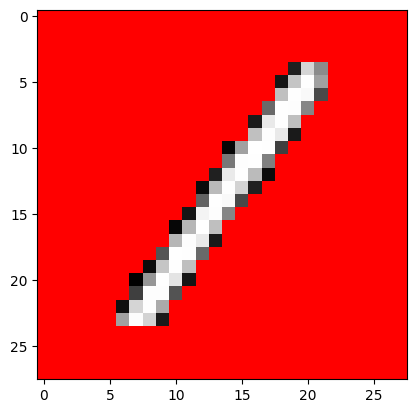

In [5]:
# Visualize images
img, label = dataset_train[np.random.randint(0, 1000)]
print(f'Image: {label}')
plt.imshow(img.transpose(0, 1).transpose(1, 2))

## Train with ERM

In [6]:
# Init model
network = model_factory(
    arch = 'lenet',
    input_shape = dataset_train[0][0].shape,
    num_classes = dataset_train.num_classes
)
network.to(device)
summary(network, dataset_train[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
             LeNet-9                   [-1, 84]               0
           Linear-10                    [-1, 5]             425
Total params: 61,581
Trainable params: 61,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.23
Estimated Tot

In [7]:
# Optimizer
optimizer=optim.SGD(network.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

In [8]:
# Train
erm = ERM(
    model = network,
    trainset = dataset_train,
    batch_size = 64,
    optimizer = optimizer,
    num_epochs = 1,
    device = device,
    verbose = True
)

erm.train()

Epoch 0: 100%|██████████| 751/751 [00:04<00:00, 161.67batch/s, accuracy=100.0%, loss=0.00621]


## Evaluate Model

In [9]:
# Evaluate cross-group accuracy
evaluator = Evaluator(
    testset = dataset_test,
    group_partition = dataset_test.group_partition,
    group_weights = dataset_train.group_weights,
    batch_size = 64,
    model = network,
    device = device,
    verbose = True
)

evaluator.evaluate()

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:04,  5.63it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:03,  5.81it/s]

Group (0, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:06,  3.55it/s]

Group (0, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:00<00:04,  4.22it/s]

Group (0, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:04,  4.47it/s]

Group (0, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:04,  4.73it/s]

Group (1, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:03,  4.85it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:01<00:03,  4.92it/s]

Group (1, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:01<00:03,  5.03it/s]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:02,  5.10it/s]

Group (1, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:02<00:02,  5.18it/s]

Group (2, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:02<00:02,  5.35it/s]

Group (2, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:02<00:02,  5.38it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:02<00:02,  5.44it/s]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:02<00:01,  5.37it/s]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:03<00:01,  5.46it/s]

Group (3, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:03<00:01,  5.06it/s]

Group (3, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:03<00:01,  5.20it/s]

Group (3, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:03<00:01,  5.30it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:03<00:00,  5.31it/s]

Group (3, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:04<00:00,  5.13it/s]

Group (4, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:04<00:00,  5.16it/s]

Group (4, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:04<00:00,  5.22it/s]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:04<00:00,  5.18it/s]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]

Group (4, 4) Accuracy: 100.0


{(0, 0): 100.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (0, 4): 0.0,
 (1, 0): 0.0,
 (1, 1): 100.0,
 (1, 2): 0.0,
 (1, 3): 0.0,
 (1, 4): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 100.0,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (3, 3): 100.0,
 (3, 4): 0.0,
 (4, 0): 0.0,
 (4, 1): 0.0,
 (4, 2): 0.0,
 (4, 3): 0.0,
 (4, 4): 100.0}

In [10]:
print(f'Spurious attribute prediction: {evaluator.evaluate_spurious_attribute_prediction()}')
print(f'Average accuracy: {evaluator.average_accuracy}')
print(f'Worst group accuracy: {evaluator.worst_group_accuracy}')

Spurious attribute prediction: 100.0
Average accuracy: 98.9938338471794
Worst group accuracy: ((0, 1), 0.0)


We see above that there is poor average accuracy across groups, which we'll try to fix

# Step 2: Clutsering Fine-Grained Subclasses
Now, we can cluster the subclasses (for example, digit 0 and 1 within our original [0, 1] group)

In [11]:
# Feature space
erm.trainer.get_trainset_outputs()

Getting Trainset Outputs: 100%|██████████| 751/751 [00:01<00:00, 438.15batch/s]


tensor([[-1.1480, -1.2238,  5.0270, -0.4660, -1.3661],
        [ 5.1075, -1.3834, -2.0516, -0.8255, -0.4146],
        [-1.1736, -1.2605,  5.2902, -0.5478, -1.3961],
        ...,
        [-1.1752, -1.2432,  5.2097, -0.5370, -1.3992],
        [-1.1966, -1.0998, -0.8616,  4.9970, -0.9956],
        [-1.2970, -2.0591, -1.1557, -0.9450,  4.8469]], device='cuda:0')

In [12]:
for pair in dataset_train.group_partition.keys():
    print(pair, len(dataset_train.group_partition[pair]))

(2, 2) 8920
(0, 0) 10031
(4, 4) 9346
(1, 1) 9575
(3, 3) 9649
(3, 1) 23
(3, 2) 29
(2, 3) 26
(4, 3) 27
(4, 2) 19
(0, 1) 31
(3, 4) 23
(0, 3) 25
(4, 0) 23
(1, 3) 20
(2, 1) 23
(1, 0) 29
(1, 2) 29
(0, 2) 22
(4, 1) 26
(1, 4) 19
(3, 0) 23
(2, 4) 25
(0, 4) 24
(2, 0) 17


In [13]:
# Cluster based on the output feature space
features = erm.trainer.get_trainset_outputs()
cluster = Cluster(
    Z = features,
    class_labels = dataset_train.labels,
    num_clusters = 2,
    device = device,
    verbose = True
)

clusters = cluster.infer_groups()

Clustering class-wise: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s]


In [14]:
for pair in sorted(clusters.keys()):
    print(pair, len(clusters[pair]))

(0, 0) 10031
(0, 1) 102
(1, 0) 9575
(1, 1) 97
(2, 0) 91
(2, 1) 8920
(3, 0) 9649
(3, 1) 98
(4, 0) 9346
(4, 1) 95


# Step 3: Retraining with Group Balancing

In [15]:
network = model_factory(
    arch = 'lenet',
    input_shape = dataset_train[0][0].shape,
    num_classes = dataset_train.num_classes
)
network.to(device)
summary(network, dataset_train[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
             LeNet-9                   [-1, 84]               0
           Linear-10                    [-1, 5]             425
Total params: 61,581
Trainable params: 61,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.23
Estimated Tot

In [16]:
# Optimizer
optimizer=optim.SGD(network.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

In [17]:
# Train using Group Balance Batch ERM
group_balance = GroupBalanceBatchERM(
    model = network,
    trainset = dataset_train,
    num_epochs = 10,
    group_partition = clusters,
    batch_size = 64,
    optimizer = optimizer,
    device = device,
    verbose = True
)
group_balance.train()

Epoch 9: 100%|██████████| 751/751 [00:03<00:00, 201.16batch/s, accuracy=100.0%, loss=5.96e-7]


In [18]:
evaluator = Evaluator(
    testset = dataset_test,
    group_partition = dataset_test.group_partition,
    group_weights = dataset_train.group_weights,
    batch_size = 64,
    model = network,
    device = device,
    verbose = True
)

evaluator.evaluate()

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:04,  5.89it/s]

Group (0, 0) Accuracy: 99.76359338061465


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:03,  5.98it/s]

Group (0, 1) Accuracy: 89.83451536643027


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:03,  5.84it/s]

Group (0, 2) Accuracy: 88.65248226950355


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:00<00:03,  5.86it/s]

Group (0, 3) Accuracy: 89.59810874704492


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:00<00:03,  6.00it/s]

Group (0, 4) Accuracy: 84.16075650118204


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:03,  5.85it/s]

Group (1, 0) Accuracy: 90.95354523227384


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:03,  5.92it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:01<00:02,  5.89it/s]

Group (1, 2) Accuracy: 87.99019607843137


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:01<00:02,  5.87it/s]

Group (1, 3) Accuracy: 77.69607843137256


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:01<00:02,  5.81it/s]

Group (1, 4) Accuracy: 64.2156862745098


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:01<00:02,  5.85it/s]

Group (2, 0) Accuracy: 92.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:02<00:02,  5.85it/s]

Group (2, 1) Accuracy: 78.93333333333334


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:02<00:02,  5.87it/s]

Group (2, 2) Accuracy: 99.46666666666667


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:02<00:01,  5.87it/s]

Group (2, 3) Accuracy: 86.66666666666667


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:02<00:01,  5.81it/s]

Group (2, 4) Accuracy: 54.27807486631016


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:02<00:01,  5.94it/s]

Group (3, 0) Accuracy: 85.678391959799


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:02<00:01,  5.91it/s]

Group (3, 1) Accuracy: 79.34508816120906


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:03<00:01,  5.93it/s]

Group (3, 2) Accuracy: 90.42821158690177


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:03<00:01,  5.89it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:03<00:00,  5.88it/s]

Group (3, 4) Accuracy: 56.1712846347607


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:03<00:00,  5.92it/s]

Group (4, 0) Accuracy: 82.61964735516372


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:03<00:00,  5.86it/s]

Group (4, 1) Accuracy: 62.21662468513854


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:03<00:00,  5.82it/s]

Group (4, 2) Accuracy: 49.87405541561713


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:04<00:00,  5.83it/s]

Group (4, 3) Accuracy: 73.23232323232324


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:04<00:00,  5.88it/s]

Group (4, 4) Accuracy: 100.0


{(0, 0): 99.76359338061465,
 (0, 1): 89.83451536643027,
 (0, 2): 88.65248226950355,
 (0, 3): 89.59810874704492,
 (0, 4): 84.16075650118204,
 (1, 0): 90.95354523227384,
 (1, 1): 100.0,
 (1, 2): 87.99019607843137,
 (1, 3): 77.69607843137256,
 (1, 4): 64.2156862745098,
 (2, 0): 92.0,
 (2, 1): 78.93333333333334,
 (2, 2): 99.46666666666667,
 (2, 3): 86.66666666666667,
 (2, 4): 54.27807486631016,
 (3, 0): 85.678391959799,
 (3, 1): 79.34508816120906,
 (3, 2): 90.42821158690177,
 (3, 3): 100.0,
 (3, 4): 56.1712846347607,
 (4, 0): 82.61964735516372,
 (4, 1): 62.21662468513854,
 (4, 2): 49.87405541561713,
 (4, 3): 73.23232323232324,
 (4, 4): 100.0}

In [19]:
print(f'Spurious attribute prediction: {evaluator.evaluate_spurious_attribute_prediction()}')
print(f'Average accuracy: {evaluator.average_accuracy}')
print(f'Worst group accuracy: {evaluator.worst_group_accuracy}')

Spurious attribute prediction: 34.42
Average accuracy: 99.63903235027645
Worst group accuracy: ((4, 2), 49.87405541561713)


Now, our model doesn't fall for the spurious correlations we injected and is more accurate across groups